In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/news-summary/news_summary_more.csv
/kaggle/input/news-summary/news_summary.csv
/kaggle/input/word2vec-for-text-summarization/__results__.html
/kaggle/input/word2vec-for-text-summarization/__notebook__.ipynb
/kaggle/input/word2vec-for-text-summarization/__output__.json
/kaggle/input/word2vec-for-text-summarization/w2v_text_summ_200d_09162019
/kaggle/input/word2vec-for-text-summarization/custom.css


**Resources - **
1. https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/
2. https://www.analyticsvidhya.com/blog/2018/11/introduction-text-summarization-textrank-python/
3. https://towardsdatascience.com/understand-text-summarization-and-create-your-own-summarizer-in-python-b26a9f09fc70
4. https://github.com/aravindpai/How-to-build-own-text-summarizer-using-deep-learning

In [2]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

# from summarizer import Summarizer,TransformerSummarizer
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [17]:
summary = pd.read_csv('/kaggle/input/news-summary/news_summary.csv', encoding='iso-8859-1')
raw = pd.read_csv('/kaggle/input/news-summary/news_summary_more.csv', encoding='iso-8859-1')

In [18]:
pre1 =  raw.iloc[:,0:2].copy()
pre2 = summary.iloc[:,0:6].copy()

In [19]:
pre = pd.DataFrame()
pre['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
pre['headlines'] = pd.concat([pre1['headlines'],pre2['headlines']],ignore_index = True)

In [20]:
pre.head(2)

,text,headlines
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...


**Seq2Seq LSTM Modelling**
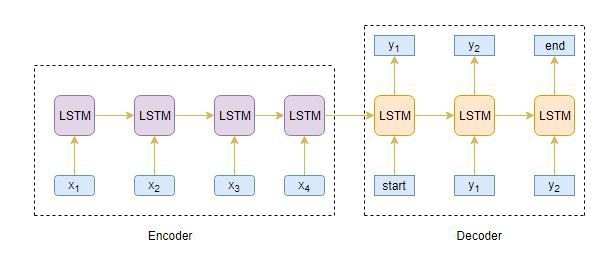

> **Perform Data Cleansing**

In [21]:
import re

#Removes non-alphabetic characters:
def text_strip(column):
    for row in column:
        
        #ORDER OF REGEX IS VERY VERY IMPORTANT!!!!!!
        
        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM
        
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)
        
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        
        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them
        

        
        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces
        
        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        
        
        yield row

In [22]:
brief_cleaning1 = text_strip(pre['text'])
brief_cleaning2 = text_strip(pre['headlines'])

In [23]:
from time import time
import spacy
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:
#If data loss seems to be happening(i.e len(text) = 50 instead of 75 etc etc) in this cell , decrease the batch_size parametre 

t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
text = [str(doc) for doc in nlp.pipe(brief_cleaning1, batch_size=5000, n_threads=-1)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 7.18 mins


In [24]:
#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:


t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
headline = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(brief_cleaning2, batch_size=5000, n_threads=-1)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 2.69 mins


In [25]:
text[0]

'saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad 360-degree career support helped him transition to data scientist at tech mahindra with 90% salary hike upgrad online power learning has powered lakh+ careers.'

In [26]:
headline[0]

'_START_ upgrad learner switches to career in ml al with 90% salary hike _END_'

In [29]:
pre['text'] = pd.Series(text)
pre['headlines'] = pd.Series(headline)

In [35]:
pre.head()

,text,headlines
0,saurav kant an alumnus of upgrad and iiit-b pg...,_START_ upgrad learner switches to career in m...
1,kunal shah credit card bill payment platform c...,_START_ delhi techie wins free food from swigg...
2,new zealand defeated india by wickets in the f...,_START_ new zealand end rohit sharma-led india...
3,with aegon life iterm insurance plan customers...,_START_ aegon life iterm insurance plan helps ...
4,speaking about the sexual harassment allegatio...,_START_ have known hirani for yrs what if meto...


In [40]:
#Check how much % of summary have 0-15 words
cnt=0
for i in pre['headlines']:
    if(len(i.split())<=15):
        cnt=cnt+1
print(cnt/len(pre['headlines']))

0.9978234465335472


In [41]:
#Check how much % of text have 0-70 words
cnt=0
for i in pre['text']:
    if(len(i.split())<=100):
        cnt=cnt+1
print(cnt/len(pre['text']))

1.0


In [42]:
#Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len=100
max_summary_len=15

In [55]:
# #Select the Summaries and Text between max len defined above

# cleaned_text =np.array(pre['cleaned_text'])
# cleaned_summary=np.array(pre['cleaned_summary'])

# short_text=[]
# short_summary=[]

# for i in range(len(cleaned_text)):
#     if(len(cleaned_summary[i].split())<=max_summary_len):
#         short_text.append(cleaned_text[i])
#         short_summary.append(cleaned_summary[i])
        
# post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [56]:
# post_pre.head(2)

In [43]:
#Add sostok and eostok at 
pre['headlines'] = pre['headlines'].apply(lambda x : 'sostok '+ x + ' eostok')


In [44]:
pre.head(2)

,text,headlines
0,saurav kant an alumnus of upgrad and iiit-b pg...,sostok _START_ upgrad learner switches to care...
1,kunal shah credit card bill payment platform c...,sostok _START_ delhi techie wins free food fro...


**SEQ2SEQ MODEL BUILDING **

Split the data to TRAIN and VALIDATION sets

In [45]:
train_size = 70000
valid_size = 10000
test_size = 1000

In [46]:
train_df = pre[: train_size]
valid_df = pre[train_size : train_size + valid_size]
test_df = pre[train_size + valid_size : train_size + valid_size + test_size]
print("train data shape is: ", train_df.shape)
print("valid data shape is: ", valid_df.shape)
print("test data shape is: ", test_df.shape)

train data shape is:  (70000, 2)
valid data shape is:  (10000, 2)
test data shape is:  (1000, 2)


In [47]:
train_df.head(1)

,text,headlines
0,saurav kant an alumnus of upgrad and iiit-b pg...,sostok _START_ upgrad learner switches to care...


In [48]:
test_df.head(1)

,text,headlines
80000,the season premiere of hbo game of thrones bec...,sostok _START_ season premiere most watched go...


In [122]:
x_tr = np.array(train_df['text'])
x_val = np.array(valid_df['text'])
x_test = np.array(test_df['text'])

y_tr = np.array(train_df['headlines'])
y_val = np.array(valid_df['headlines'])
y_test = np.array(test_df['headlines'])

In [123]:
y_test[0]

'sostok _START_ season premiere most watched got episode in showã¢â\x80â\x99s history _END_ eostok'

In [124]:
# from sklearn.model_selection import train_test_split
# x_tr1,x_val1,y_tr1,y_val1=train_test_split(np.array(pre['text']),np.array(pre['headlines']),test_size=0.1,random_state=0,shuffle=True)

In [125]:
# x_tr1[0]

In [126]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

**RARE WORD ANALYSIS FOR X i.e 'text'**
* tot_cnt gives the size of vocabulary (which means every unique words in the text)

* cnt gives me the no. of rare words whose count falls below threshold

* tot_cnt - cnt gives me the top most common words

In [127]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 57.548588533535764
Total Coverage of rare words: 1.4897859067803156


In [128]:

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)
x_test_seq  =   x_tokenizer.texts_to_sequences(x_test)
#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')
x_test  =   pad_sequences(x_test_seq, maxlen=max_text_len, padding='post')
#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 29641


**RARE WORD ANALYSIS FOR Y i.e 'summary'**
* tot_cnt gives the size of vocabulary (which means every unique words in the text)

* cnt gives me the no. of rare words whose count falls below threshold

* tot_cnt - cnt gives me the top most common words

In [129]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [130]:
thresh=2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 37.41929266647393
Total Coverage of rare words: 1.2063489433443693


In [131]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 
y_test_seq   =   y_tokenizer.texts_to_sequences(y_test) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')
y_test  =   pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 19483


We will now remove "Summary" i.e Y (train,val,test) which has only _START_ and _END_

In [132]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [133]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [134]:
ind=[]
for i in range(len(y_test)):
    cnt=0
    for j in y_test[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_test=np.delete(y_test,ind, axis=0)
x_test=np.delete(x_test,ind, axis=0)

In [135]:
y_test[0]

array([    3,     2,  1414, 10528,   140,  4334,   387,  7107,     6,
         592,     1,     4,     0,     0,     0], dtype=int32)

In [148]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Size of vocabulary from the w2v model = 29641
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     5928200     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 300), ( 601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
________________________________________________

In [149]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [150]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


**Start fitting the model with the data**

In [151]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 70000 samples, validate on 10000 samples
Epoch 1/50
70000/70000 [==============================] - 293s 4ms/sample - loss: 5.4874 - val_loss: 4.9292
Epoch 2/50
70000/70000 [==============================] - 292s 4ms/sample - loss: 5.0345 - val_loss: 4.6849
Epoch 3/50
70000/70000 [==============================] - 295s 4ms/sample - loss: 4.7775 - val_loss: 4.4973
Epoch 4/50
70000/70000 [==============================] - 290s 4ms/sample - loss: 4.5712 - val_loss: 4.3514
Epoch 5/50
70000/70000 [==============================] - 288s 4ms/sample - loss: 4.4187 - val_loss: 4.2502
Epoch 6/50
70000/70000 [==============================] - 288s 4ms/sample - loss: 4.3024 - val_loss: 4.1730
Epoch 7/50
70000/70000 [==============================] - 287s 4ms/sample - loss: 4.2091 - val_loss: 4.1141
Epoch 8/50
70000/70000 [==============================] - 286s 4ms/sample - loss: 4.1234 - val_loss: 4.0596
Epoch 9/50
70000/70000 [==============================] - 286s 4ms/sample - loss: 4.04

In [153]:
import ModelCheckpoint

ModuleNotFoundError: No module named 'ModelCheckpoint'

In [152]:
checkpoint_path = "/kaggle/working/my_model.ckpt"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

NameError: name 'ModelCheckpoint' is not defined

**Visualize the model learning**

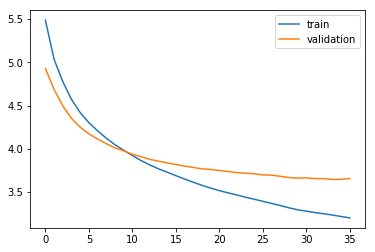

In [154]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

**Next, let’s build the dictionary to convert the index to word for target and source vocabulary:**

In [155]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [156]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

**We are defining a function below which is the implementation of the inference process**

In [157]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

**Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:**


In [158]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

**Run the model over the data to see the results**

In [159]:
for i in range(0,10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: saurav kant an alumnus of upgrad and iiit b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad 360 degree career support helped him transition to data scientist at tech mahindra with 90 salary hike upgrad online power learning has powered lakh careers 
Original summary: start upgrad learner switches to career in ml al with 90 salary hike end 
Predicted summary:  start upgrad helps of the biggest ever in india end


Review: kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending 2000 cred coins users get one cred coin per rupee of bill paid which can be used to avail rewards from brands like bookmyshow ubereats cult fit and more 
Original summary: start delhi techie wins free food from swiggy for one year on cred end 
Predicted summary:  start delhi govt launches 

In [160]:
for i in range(0,10):
    print("Review:",seq2text(x_test[i]))
    print("Original summary:",seq2summary(y_test[i]))
    print("Predicted summary:",decode_sequence(x_test[i].reshape(1,max_text_len)))
    print("\n")

Review: the season premiere of hbo game of thrones became the most watched in the show history with 10 1 million viewers tuning in to the live broadcast as per hbo this season first episode beat viewership for last year season finale which had 8 89 million viewers it was also the most tweeted got episode ever with 2 4 million tweets 
Original summary: start season premiere most watched got episode in history end 
Predicted summary:  start game of thrones actor kit gets 10 billion from film end


Review: president pranab mukherjee is entitled to salary of ã¢ââ¹75 000 per month half of his salary as president after he retires on july 24 he will further be entitled to office expenses of ã¢ââ¹60 000 per annum mobile phone car and free travel across india he will live in the delhi bungalow where former president dr apj abdul kalam stayed 
Original summary: start what will president pranab mukherjee earn post retirement end 
Predicted summary:  start prez kovind announces pay for lakh over

In [167]:
df_temp=pd.DataFrame(test_df.head(100))
df_temp.shape

(100, 2)

In [168]:
df_temp.head()

,text,headlines
80000,the season premiere of hbo game of thrones became the most watched in the show history with 10.1 million viewers tuning in to the live broadcast as per hbo this season first episode beat viewershi...,sostok _START_ season premiere most watched got episode in showã¢ââs history _END_ eostok
80001,president pranab mukherjee is entitled to salary of ã¢ââ¹75 000 per month half of his salary as president after he retires on july 24 he will further be entitled to office expenses of ã¢ââ¹60 00...,sostok _START_ what will president pranab mukherjee earn post retirement _END_ eostok
80002,singer ed sheeran deleted his twitter account on monday after announcing earlier this month that he taking break from the social media platform go on it and there nothing but people saying mean th...,sostok _START_ singer ed sheeran deletes his twitter account _END_ eostok
80003,nawazuddin siddiqui while speaking about his tweet about being discriminated in the film industry on the basis of his skin colour said it was just reply to someone in the film industry nawazuddin ...,sostok _START_ was reply to someone siddiqui on tweet about skin colour _END_ eostok
80004,twitter has deleted nearly 90 000 fake accounts after security researchers discovered massive pornographic botnet that was posting links to scam websites and offering online sex the fake profiles ...,sostok _START_ twitter deletes 90 000 fake accounts that offered online sex _END_ eostok


In [169]:
predictions = []
for i in range(0,100):
    prediction = decode_sequence(x_test[i].reshape(1,max_text_len))
    predictions.append(prediction)
    
df_temp['predictions'] = predictions

In [170]:
df_temp['headlines'] = df_temp['headlines'].str.replace('sostok _START_ ', '')
df_temp['headlines'] = df_temp['headlines'].str.replace(' _END_ eostok', '')

In [171]:
df_temp.head()

,text,headlines,predictions
80000,the season premiere of hbo game of thrones became the most watched in the show history with 10.1 million viewers tuning in to the live broadcast as per hbo this season first episode beat viewershi...,season premiere most watched got episode in showã¢ââs history,start game of thrones actor kit gets 10 billion from film end
80001,president pranab mukherjee is entitled to salary of ã¢ââ¹75 000 per month half of his salary as president after he retires on july 24 he will further be entitled to office expenses of ã¢ââ¹60 00...,what will president pranab mukherjee earn post retirement,start prez kovind announces pay for lakh over lakh people end
80002,singer ed sheeran deleted his twitter account on monday after announcing earlier this month that he taking break from the social media platform go on it and there nothing but people saying mean th...,singer ed sheeran deletes his twitter account,start twitter users react to twitter account hacked end
80003,nawazuddin siddiqui while speaking about his tweet about being discriminated in the film industry on the basis of his skin colour said it was just reply to someone in the film industry nawazuddin ...,was reply to someone siddiqui on tweet about skin colour,start nawazuddin is the name of the film nawazuddin end
80004,twitter has deleted nearly 90 000 fake accounts after security researchers discovered massive pornographic botnet that was posting links to scam websites and offering online sex the fake profiles ...,twitter deletes 90 000 fake accounts that offered online sex,start facebook faces global outage for fake news end


In [177]:
df_temp.to_csv('/kaggle/working/final_seq2seq_generations.csv', index=False)

In [174]:
!pip install nltk

In [175]:
!pip install rouge-score

In [176]:
from rouge_score import rouge_scorer
import pandas as pd


scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores for each pair of prediction and reference
rouge_scores = []
for pred, ref in zip(df_temp['predictions'],df_temp['headlines']):
    scores = scorer.score(pred, ref)
    rouge_scores.append(scores)

# Extract ROUGE scores
rouge_1_scores = [score['rouge1'].fmeasure for score in rouge_scores]
rouge_2_scores = [score['rouge2'].fmeasure for score in rouge_scores]
rouge_l_scores = [score['rougeL'].fmeasure for score in rouge_scores]

# Add ROUGE scores as new columns in the original DataFrame
df_temp['ROUGE-1'] = rouge_1_scores
df_temp['ROUGE-2'] = rouge_2_scores
df_temp['ROUGE-L'] = rouge_l_scores

TypeError: 'type' object is not subscriptable